# Binary Classification Algorithms

# MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # Fetch as NumPy array instead of images

X, y = mnist.data, mnist.target

c:\Users\Adis Veletanlic\Git\machine-learning\.venv\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


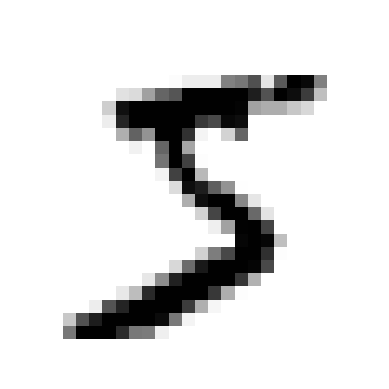

Description of image: 5


In [3]:
import matplotlib.pyplot as plt

# Approximately 70,000 images, each with 784 features
# Grab an instance's feature vector, reshape it a 28x28 array, and display it using Matplotlib's imshow() function

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

# The label tells us that it is a '5'
print(f'Description of image: {y[0]}')

# Training a binary classifier

In [4]:
# Use stochastic gradient descent classifier
from sklearn.linear_model import SGDClassifier

# Always create a test set and set it aside before inspecting the data closely.
# MNIST dataset is already split into training and testing sets, as well as already being shuffled.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Use classifier to detect images of the number 5
sgd_clf.predict([some_digit])

array([ True])

# Evaluate model performance

This example demonstrates why accuracy is generally not the preferred performance measure for classifiers,
simply because in this case for example only about 10% of images are 5's, so the classifier is right approximately
90% of the time (i.e., some classes are much more frequent than others)

In [5]:
# Use the cross_val_score function to evaluate SGDClassifier model, using k-fold cross-validation with three folds. 

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

# Confusion matrices

In [6]:
# First we need a set of predictions that can be compared to the actual targets.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [7]:
# Generate confusion matrix from target classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

# A perfect confusion matrix would only have non-zero values on its main diagonal

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

# Precision and recall

Precision measures the accuracy of positive predictions, while recall measures the completeness of positive predictions

In [8]:
from sklearn.metrics import precision_score, recall_score

# When our classifier claims an image represents a 5, it is correct only 83.7% of the time.
print(f"Precision score: {precision_score(y_train_5, y_train_pred)}")

# Our classifier also only detects 65.1% of all 5's
print(f"Recall score: {recall_score(y_train_5, y_train_pred)}")

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


In [9]:
# It is common to combine the precision and recall into a single metric called the F1 score.
# It is useful when you need a single metric to compare two classifiers

# An F1 score is a harmonic mean of precision and recall. Whereas the regular mean treats all values equally, 
# the harmonic mean gives more weight to ow values - as a result, the classifier will only get a high F1 score if both recall and precision are high

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

# Precision/recall trade-off

Instead of calling the classifier’s predict() method, you can call its decision_function() method, 
which returns a score for each instance, and then use any threshold you want to make predictions based on those scores

In [10]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

# The SGDClassifier uses a threshold equal to 0, so the preceding code returns the same result 
# as the predict() method (i.e., True). Let’s raise the threshold:

threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

# This confirms that raising the threshold decreases recall

array([False])

# How to decide which threshold to use

In [11]:
# Use cross_val_predict function on all instances in the training set but
# specify you wan to return decision scores instead of predictions

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

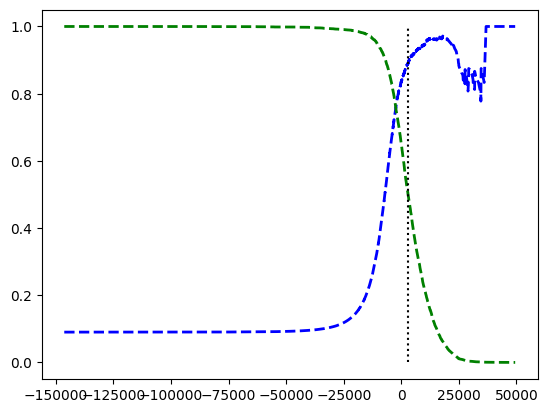

In [12]:
# Using these scores we can use the precision_recall_curve function to compute
# precision and recall for all possible thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Use Matplotplib to plot precision and recall as functrions of the threshold value

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

# At this threshold value, precision is near 90% and recall is around 50%

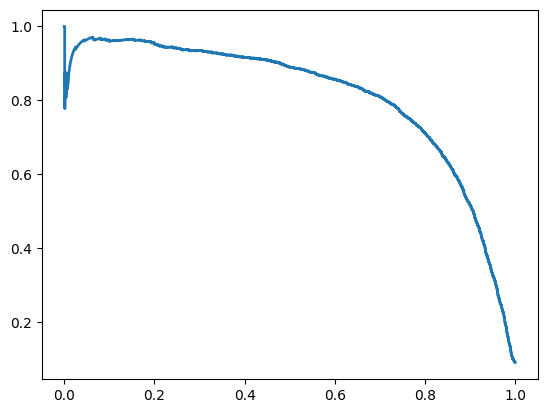

In [13]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

We can see that precision really starts to fall sharply at around 80% recall. 
We will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall.

Let's say we decide to aim for 90% precision. We could use the first plot to find
the threshold we need to use, but that might not be very precise. We can instead search for the lowest
threshold that gives at least 90% precision.

In [14]:
# We can utilize NumPy array's argmax function for this

idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [15]:
# To make predictions (on the training set for now), 
# instead of calling the classifier’s predict() method, we can run this code:

y_train_pred_90 = (y_scores >= threshold_for_90_precision)

# Now check these predictions' precision and recall
print(f'Precision score: {precision_score(y_train_5, y_train_pred_90)}')
print(f'Recall score: {recall_score(y_train_5, y_train_pred_90)}')

Precision score: 0.9000345901072293
Recall score: 0.4799852425751706


# The ROC curve

Instead of plotting precision versus recall, the ROC curve plots the *true positive rate* (TNR) against the *false positive rate* (FPR).
The FPR is the ratio of negative instances that are incorrectly classified as positive. The TNR is also called *specificity*.

In other words, the ROC curve plots *sensitivity* against *specificity*.

In [16]:
# Use roc_curve() function to compute the TPR and FPR for various threshold values

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold.

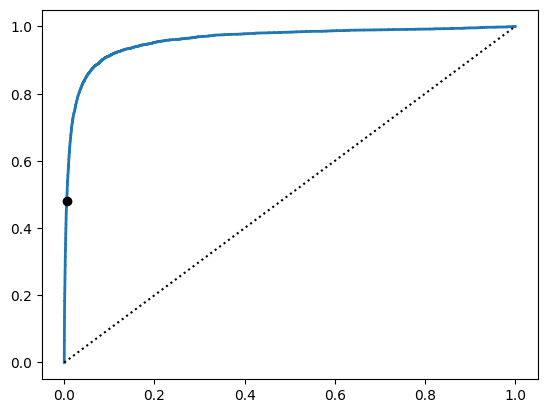

In [17]:
# Plot FPR against TPR using Matplotlib

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line in the graph represents a completely random classifier;
a good classifier should stay *as far away as possible* from that line.

A way of comparing classifiers is by calculating the area under the curve (integral). A perfect classifier would have an area of 1, a purely random classifier will always have an area of 0.5.

We can estimate the area under the curve for the ROC with the roc_auc_score function

In [18]:
from sklearn.metrics import roc_auc_score
print(f'Approximate ROC AUC score: {roc_auc_score(y_train_5, y_scores):.2f}')

Approximate ROC AUC score: 0.96


As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

We will now create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The precision_recall_curve() function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance. But since the RandomForestClassifier does not have a decision_function() method, we need to use the predict_proba() function that returns class probabilities for each instance, then we can use the probability of the positive class as a score.

In [20]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, method="predict_proba")

# Look at the class probabilities for the first two images in the training set
print(f'{y_probas_forest[:2]}')

[[0.14 0.86]
 [0.99 0.01]]


The second column contains the estimated probabilities for the positive class, so let’s pass them to the precision_recall_curve() function

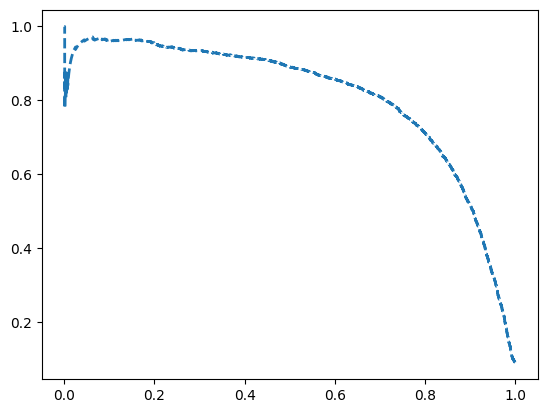

In [21]:
y_scores_forest = y_probas_forest[:, 1]
precision_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

# Plot the PR curve
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

The RandomForestClassifier’s PR curve looks much better than the SGDClassifier’s: it comes much closer to the top-right corner. Its F1 score and ROC AUC score are also significantly better

In [22]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5

print(f'F1 score of RandomForestClassifier: {f1_score(y_train_5, y_train_pred_forest)}')
print(f'AUC score of RandomForestClassifier: {roc_auc_score(y_train_5, y_scores_forest)}')

F1 score of RandomForestClassifier: 0.9314961399394116
AUC score of RandomForestClassifier: 0.998402186461512


Choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use several metrics and curves to compare various models.

# Multiclass Classification Algorithms

Multiclass classifiers can distinguish between more than two classes. A way to creata system that can classify the digit images into 10 classes is to train 10 binary classifiers independently, one for each digit. Then retrieve the decision score from each classifier for that image and select the class whose classifier outputs the highest score. This is called *one-versus-the-rest*, or *one-versus-all*.

Another strategy is to train a binary classifier for every pair of digits, i.e., if there are *N* classes, you need to train *N x (N - 1) / 2* classifiers. This is also called *one-versus-one* strategy. For most binary classification algorithms OvR is preferred.

In [23]:
# Use support vector machine classifier and train first 2,000 images.
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [ ]:
# Make a prediction on an image
print(f'Prediction: {svm_clf.predict([some_digit])}')

This code made 45 predictions — one per pair of classes — and it selected the class that won the most 'duels'.